# Checkpoint 3:
## XGBoost

In [172]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv

--2023-10-11 00:41:48--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9788953 (9.3M) [text/plain]
Saving to: ‘hotels_train.csv.4’

hotels_train.csv.4  100%[===================>]   9.33M  --.-KB/s    in 0.1s    

2023-10-11 00:41:49 (85.2 MB/s) - ‘hotels_train.csv.4’ saved [9788953/9788953]



In [173]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv

--2023-10-11 00:41:49--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4432981 (4.2M) [text/plain]
Saving to: ‘hotels_test.csv.4’

hotels_test.csv.4   100%[===================>]   4.23M  --.-KB/s    in 0.09s   

2023-10-11 00:41:49 (45.0 MB/s) - ‘hotels_test.csv.4’ saved [4432981/4432981]



In [174]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
import xgboost as xgb

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [175]:
df = pd.read_csv("hotels_train.csv")

df_filtrado = df.copy()

# Modificando el Dataset

In [177]:
df_filtrado = df_filtrado.drop('id', axis=1)

In [179]:
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)
df_filtrado.agent = df_filtrado.agent.replace(np.nan, -1)
df_filtrado.company = df_filtrado.company.replace(np.nan, -1)
df_filtrado['country'] = df_filtrado['country'].replace(np.nan, 'PRT')

In [180]:
df_filtrado = df_filtrado.replace({'adults': 0}, value=2)
df_filtrado = df_filtrado.replace({'children': 10}, value=0)
df_filtrado = df_filtrado.replace({'babies': 9}, value=0)
df_filtrado = df_filtrado.replace({'adr': -6.38}, value=df_filtrado['adr'].median())
df_filtrado = df_filtrado.replace({'adr': 0}, value=df_filtrado['adr'].median())

# Encodeando y Separando Columnas

Usando una prroporción de 70 y 30 separo mi dataset en train y validation

In [192]:
ds_encodeado = pd.get_dummies(df_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)
ds_encodeado.head(3)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,49,2016,37,5,1,2,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4,2015,44,31,0,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,25,2016,42,13,0,1,2,2.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [193]:
ds_trabajo_x=ds_encodeado.drop(['is_canceled'], axis='columns', inplace=False)

ds_trabajo_y = ds_encodeado['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=20)

# Entrenamiento y predicción

## Busqueda de Hiperparametros

In [194]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

#Cantidad de combinaciones que quiero porbar
n=50

#Conjunto de parámetros que quiero usar
params_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': list(range(3, 50)),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': list(range(100, 1001)),
    'objective':['binary:logistic'],
    'gamma': [0, 1, 2, 3, 4, 5],
    'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'lambda': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
}


#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
xgb_model = xgb.XGBClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=xgb_model,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);


In [195]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'subsample': 0.7, 'objective': 'binary:logistic', 'n_estimators': 638, 'max_depth': 25, 'learning_rate': 0.1, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1.0, 'alpha': 0.1}
0.8772895818814327


In [197]:
# {'subsample': 0.8, 'objective': 'binary:logistic', 'n_estimators': 800, 'max_depth': 10,
#  'learning_rate': 0.1, 'lambda': 0, 'gamma': 2, 'colsample_bytree': 0.9, 'alpha': 0.5}
xgb_model = xgb.XGBClassifier(subsample=randomcv.best_params_['subsample'],
                              objective=randomcv.best_params_['objective'],
                              n_estimators=randomcv.best_params_['n_estimators'],
                              max_depth=randomcv.best_params_['max_depth'],
                              learning_rate=randomcv.best_params_['learning_rate'],
                              reg_lambda=randomcv.best_params_['lambda'],
                              gamma=randomcv.best_params_['gamma'],
                              colsample_bytree=randomcv.best_params_['colsample_bytree'],
                              alpha=randomcv.best_params_['alpha']
                              )
xgb_model.fit(x_train.sort_index(axis=1), y_train)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=638, n_jobs=None,
              num_parallel_tree=None, ...)

In [199]:
y_pred = xgb_model.predict(x_test.sort_index(axis=1))
#Valores Predichos
y_pred

array([1, 1, 1, ..., 1, 0, 0])

In [200]:
y_test.values

array([1, 1, 1, ..., 1, 1, 0])

In [201]:
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head(10)

,test,pred
0,1,1
1,1,1
2,1,1
3,0,0
4,1,1
5,1,1
6,1,1
7,0,0
8,1,1
9,1,1


Text(50.722222222222214, 0.5, 'True')

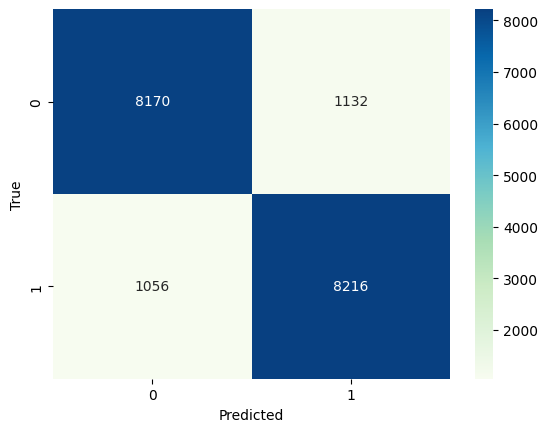

In [202]:
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [203]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8822009260256273
Recall: 0.8861087144089732
Precision: 0.8789045785194695
f1 score: 0.8824919441460796


In [204]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      9302
           1       0.88      0.89      0.88      9272

    accuracy                           0.88     18574
   macro avg       0.88      0.88      0.88     18574
weighted avg       0.88      0.88      0.88     18574



# Test prediction

## Modifico el Dataset

In [205]:
df_test = pd.read_csv("hotels_test.csv")

df_test_filtrado = df_test.copy()

In [207]:
df_test_ids = df_test['id']
df_test_filtrado = df_test_filtrado.drop('id', axis=1)
df_test_filtrado = df_test_filtrado.drop('reservation_status_date', axis=1)

In [208]:
df_test_filtrado['country'] = df_test_filtrado['country'].replace(np.nan, 'PRT')
df_test_filtrado.agent = df_test_filtrado.agent.replace(np.nan, -1)
df_test_filtrado.company = df_test_filtrado.company.replace(np.nan, -1)
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)

Tratamos de eliminar los paises que solo aparecen en el set de test y no en el de train.

In [213]:
lista_paises_unicos_test = df_test_filtrado['country'].unique()
lista_paises_unicos = df_filtrado['country'].unique()
conjunto1 = set(lista_paises_unicos)
conjunto2 = set(lista_paises_unicos_test)


# Obtener los elementos que están en conjunto1 pero no en conjunto2
elementos_en_lista1_no_en_lista2 = list(conjunto2 - conjunto1)
print(elementos_en_lista1_no_en_lista2)

df_test_filtrado["country"] = df_test_filtrado["country"].replace(to_replace=elementos_en_lista1_no_en_lista2, value="PRT")

['ASM', 'KHM', 'TMP', 'SLV', 'DMA', 'UZB', 'BFA', 'NIC', 'ATF', 'MLI', 'SMR', 'DJI']


In [216]:
df_test_filtrado["adults"] = df_test_filtrado["adults"].replace(to_replace=0, value=2)
df_test_filtrado["adr"] = df_test_filtrado["adr"].replace(to_replace=0, value=df_filtrado['adr'].median())

In [221]:
df_test_encodeado = pd.get_dummies(df_test_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)


## Prediccion

In [222]:
lista = df_test_encodeado.columns
columnas_faltantes = []
for colum in ds_encodeado.columns:
  if(colum not in lista and colum != "is_canceled"):
    print(colum)
    columnas_faltantes.append(colum)

for colum_faltante in columnas_faltantes:
  df_test_encodeado[colum_faltante] = 0

country_ARM
country_AZE
country_BEN
country_CIV
country_COM
country_ETH
country_FJI
country_FRO
country_GTM
country_HND
country_KEN
country_KNA
country_MDG
country_MNE
country_MUS
country_MYT
country_NAM
country_PAN
country_PYF
country_SDN
country_SYC
country_SYR
country_TGO
country_UMI
country_VGB
country_ZMB
market_segment_Undefined
distribution_channel_Undefined
assigned_room_type_L


Hay filas que con paises que no estuvieron en el set de entrenamiento.

In [226]:
print('todas las columnas que no aparecen en neustro otro dataset:')
lista = df_test_encodeado.columns
for colum in ds_encodeado.columns:
  if(colum not in lista):
    print(colum)

todas las columnas que no aparecen en neustro otro dataset:
is_canceled


In [227]:
test_pred_2 = xgb_model.predict(df_test_encodeado.sort_index(axis=1))
#Valores Predichos
test_pred_2

array([1, 1, 0, ..., 1, 1, 0])

In [231]:
# Crear un DataFrame con las columnas "id" e "is_canceled"
data = {'id': df_test_ids, 'is_canceled': test_pred_2}
df_final_finalisimo = pd.DataFrame(data)

In [232]:
df_final_finalisimo.isna().any()

id             False
is_canceled    False
dtype: bool

In [233]:
df_final_finalisimo.head(10)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
5,c142b61c-3035-46e7-8cf7-3720a29d0d61,1
6,8c4171ad-9837-4468-ac8e-8cb3d5a41b55,0
7,3ce60033-4529-4314-be77-db4a7737f326,0
8,7ab807a4-5e90-4205-b66e-0188696cc34b,0
9,a0ab0509-c8b0-4a2c-9f27-21f26e186520,0


In [234]:
df_final_finalisimo.to_csv('submission.csv', index=False)
